### 1. Setup and Data Loading

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from category_encoders import CatBoostEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sentence_transformers import SentenceTransformer
import warnings

warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('ramen-ratings.csv')
df.set_index('Review #', inplace=True)
print('Dataset Shape:', df.shape)
df.head()

Dataset Shape: (2580, 6)


,Brand,Variety,Style,Country,Stars,Top Ten
Review #,,,,,,
2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN
2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1,NaN
2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN
2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN
2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN


### 2. Initial Cleaning and EDA


In [6]:
df['Stars'] = pd.to_numeric(df['Stars'], errors='coerce')
df.dropna(subset=['Stars'], inplace=True)

df['Top Ten'].fillna('0', inplace=True)
df['is_top_ten'] = df['Top Ten'].apply(lambda x: 0 if x == '0' else 1)
df.drop('Top Ten', axis=1, inplace=True)

df.shape

(2577, 6)

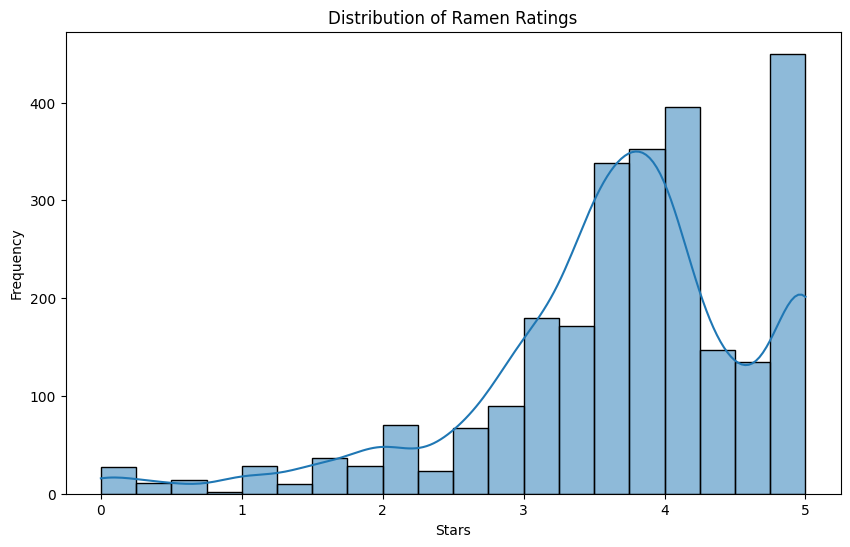

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Stars'], bins=20, kde=True)
plt.title('Distribution of Ramen Ratings')
plt.xlabel('Stars')
plt.ylabel('Frequency')
plt.show()

### 3. Text Feature Engineering with Sentence-BERT

In [8]:
model = SentenceTransformer('all-MiniLM-L6-v2')
variety_embeddings = model.encode(df['Variety'].tolist(), show_progress_bar=True)
print('Embeddings Shape:', variety_embeddings.shape)

Batches: 100%|██████████| 81/81 [00:05<00:00, 13.67it/s]

Embeddings Shape: (2577, 384)


In [9]:
embedding_df = pd.DataFrame(variety_embeddings, index=df.index)
embedding_df.columns = [f'variety_emb_{i}' for i in range(variety_embeddings.shape[1])]

df_processed = pd.concat([df.drop('Variety', axis=1), embedding_df], axis=1)

df_processed.shape

(2577, 389)

### 4. Dimensionality Reduction and Clustering

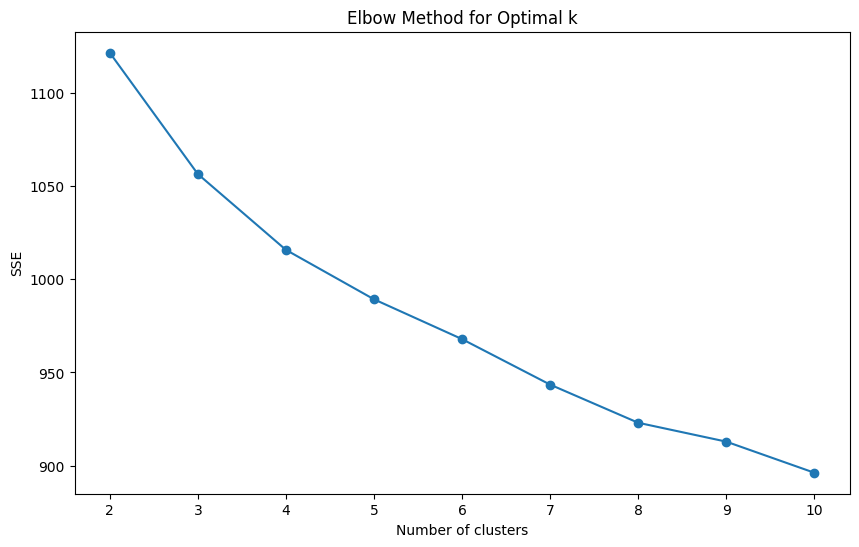

In [10]:
pca = PCA(n_components=50)
embeddings_reduced = pca.fit_transform(variety_embeddings)

sse = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=57)
    kmeans.fit(embeddings_reduced)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [11]:
kmeans = KMeans(n_clusters=5, random_state=57)
df_processed['variety_cluster'] = kmeans.fit_predict(embeddings_reduced)

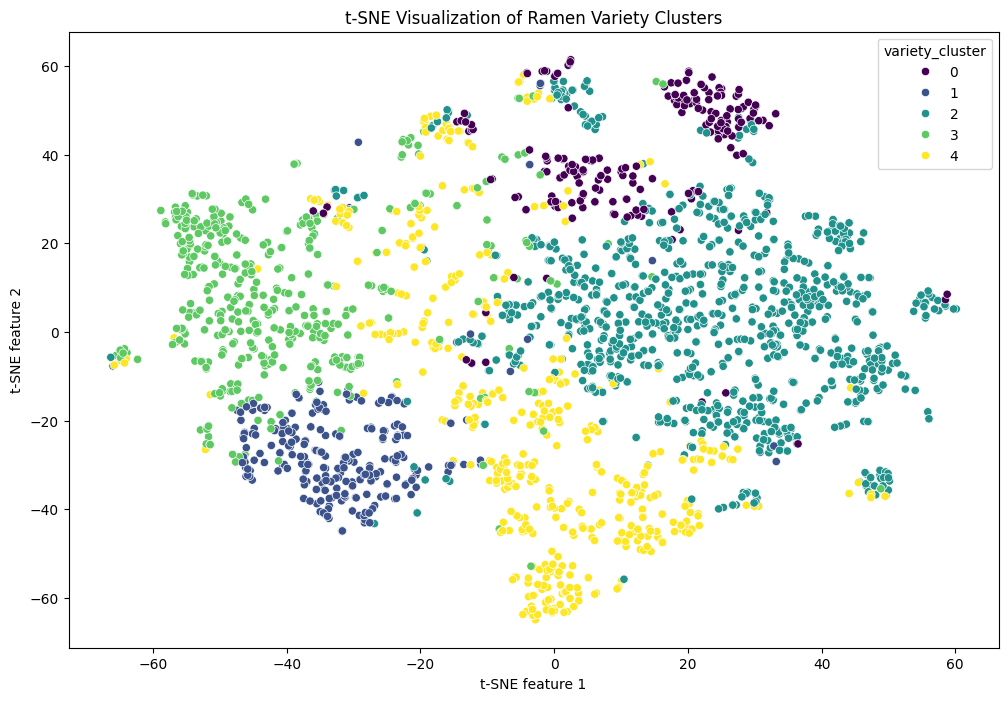

In [12]:
tsne = TSNE(n_components=2, random_state=57)
embeddings_tsne = tsne.fit_transform(embeddings_reduced)
plt.figure(figsize=(12, 8))
sns.scatterplot(x=embeddings_tsne[:, 0], y=embeddings_tsne[:, 1],
                hue=df_processed['variety_cluster'], palette='viridis')
plt.title('t-SNE Visualization of Ramen Variety Clusters')
plt.xlabel('t-SNE feature 1'); plt.ylabel('t-SNE feature 2')
plt.show()

### 5. Categorical Feature Engineering and Feature Selection

In [13]:
target = 'Stars'
categorical_features = ['Brand', 'Style', 'Country']

X_full = df_processed.drop(columns=[target])
y_full = df_processed[target]

X_train, X_test, y_train, y_test = train_test_split( X_full, y_full, test_size=0.2, random_state=57)

In [14]:
# CatBoostEncoder on categorical columns
cat_encoder = CatBoostEncoder(cols=categorical_features)
X_train_encoded = cat_encoder.fit_transform(X_train, y_train)
X_test_encoded  = cat_encoder.transform(X_test)

In [15]:
df_encoded = pd.concat([X_train_encoded, X_test_encoded]).sort_index()
df_processed = pd.concat([df_encoded, y_full], axis=1)  # keep Stars aligned

df_processed.shape

df_processed.head()

,Brand,Style,Country,is_top_ten,variety_emb_0,variety_emb_1,variety_emb_2,variety_emb_3,variety_emb_4,variety_emb_5,...,variety_emb_376,variety_emb_377,variety_emb_378,variety_emb_379,variety_emb_380,variety_emb_381,variety_emb_382,variety_emb_383,variety_cluster,Stars
Review #,,,,,,,,,,,,,,,,,,,,,
1,3.641897,3.695318,3.381775,0,-0.033419,0.043364,0.017656,0.009185,-0.012756,-0.012781,...,-0.002649,0.010169,0.021304,-0.027322,-0.013849,0.032777,-0.039274,0.026079,1,0.5
2,2.914595,3.706864,3.391552,0,-0.127946,-0.023724,0.013316,-0.058578,-0.044750,0.036498,...,0.021764,0.025044,-0.006425,-0.045526,-0.024698,0.009744,0.055190,-0.048107,0,2.0
3,2.840700,3.687078,3.349486,0,-0.126256,0.032873,0.000950,-0.077178,-0.063134,-0.028888,...,0.026240,0.060703,0.000836,-0.004264,-0.006572,0.015426,0.054819,0.006474,0,2.0
4,2.985136,3.705094,3.409677,0,-0.139653,-0.025586,-0.002901,0.099757,-0.070216,-0.014625,...,0.019349,-0.029117,0.063175,0.001268,-0.013387,0.015482,-0.000821,0.066207,2,1.0
5,3.049662,3.630708,3.176480,0,-0.079895,0.022555,0.012004,0.033568,-0.070995,-0.001656,...,-0.000696,-0.023479,0.035456,-0.013986,0.031379,0.096622,-0.023745,0.060604,2,3.5


In [16]:
# Feature Selection using Correlation
correlation_matrix = df_processed.corr()
target_correlation = correlation_matrix['Stars'].abs().sort_values(ascending=False)
print('Top 20 most correlated features with Stars:\n', target_correlation.head(20))


Top 20 most correlated features with Stars:
 Stars              1.000000
Brand              0.364885
Country            0.311783
variety_emb_319    0.198607
variety_emb_201    0.173144
variety_emb_223    0.170531
variety_emb_252    0.160439
is_top_ten         0.153233
variety_emb_212    0.152092
variety_emb_330    0.140242
variety_emb_194    0.137202
variety_emb_349    0.136099
variety_emb_301    0.133622
variety_emb_74     0.131265
variety_emb_127    0.127502
variety_emb_1      0.123976
variety_emb_263    0.123810
variety_emb_195    0.121149
variety_emb_92     0.120346
variety_emb_217    0.119178
Name: Stars, dtype: float64


In [17]:
# Feature Selection using Lasso Regression
X = df_processed.drop('Stars', axis=1)
y = df_processed['Stars']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lasso = LassoCV(cv=5, random_state=57)
lasso.fit(X_scaled, y)

selected_features = X.columns[(lasso.coef_ != 0)]
print(f'Lasso selected {len(selected_features)} features out of {X.shape[1]}.')
print('Selected features:\n', selected_features.tolist())


Lasso selected 59 features out of 389.
Selected features:
 ['Brand', 'Country', 'is_top_ten', 'variety_emb_18', 'variety_emb_19', 'variety_emb_20', 'variety_emb_23', 'variety_emb_32', 'variety_emb_38', 'variety_emb_42', 'variety_emb_45', 'variety_emb_49', 'variety_emb_53', 'variety_emb_67', 'variety_emb_79', 'variety_emb_85', 'variety_emb_89', 'variety_emb_91', 'variety_emb_92', 'variety_emb_95', 'variety_emb_103', 'variety_emb_108', 'variety_emb_113', 'variety_emb_134', 'variety_emb_138', 'variety_emb_141', 'variety_emb_144', 'variety_emb_152', 'variety_emb_155', 'variety_emb_158', 'variety_emb_160', 'variety_emb_165', 'variety_emb_171', 'variety_emb_172', 'variety_emb_186', 'variety_emb_188', 'variety_emb_189', 'variety_emb_194', 'variety_emb_195', 'variety_emb_207', 'variety_emb_212', 'variety_emb_217', 'variety_emb_226', 'variety_emb_229', 'variety_emb_231', 'variety_emb_250', 'variety_emb_263', 'variety_emb_276', 'variety_emb_283', 'variety_emb_284', 'variety_emb_296', 'variety_em

### 6. Modeling and Evaluation

In [18]:
X_selected = df_processed[selected_features]
y = df_processed['Stars']

# Re-split to get identical train/test indices as after encoding
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    X_selected, y, test_size=0.2, random_state=57
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(n_estimators=1000, random_state=57, n_jobs=-1))
])
pipeline.fit(X_train_sel, y_train_sel)
y_pred = pipeline.predict(X_test_sel)

rmse = np.sqrt(mean_squared_error(y_test_sel, y_pred))
mae = mean_absolute_error(y_test_sel, y_pred)

print(f'Root Mean Squared Error: {rmse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')

Root Mean Squared Error: 0.8615
Mean Absolute Error: 0.6383
